In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

Training Autoencoder...
Autoencoder Epoch [1/3], Loss: 0.9281
Autoencoder Epoch [2/3], Loss: 0.9266
Autoencoder Epoch [3/3], Loss: 0.9272
Training GAN...
GAN Epoch [1/3], D Loss: 0.5563, G Loss: 3.1054
GAN Epoch [2/3], D Loss: 1.0855, G Loss: 1.7470
GAN Epoch [3/3], D Loss: 0.2420, G Loss: 3.0528


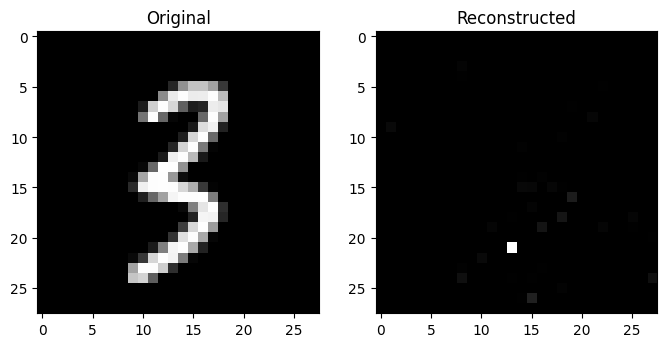

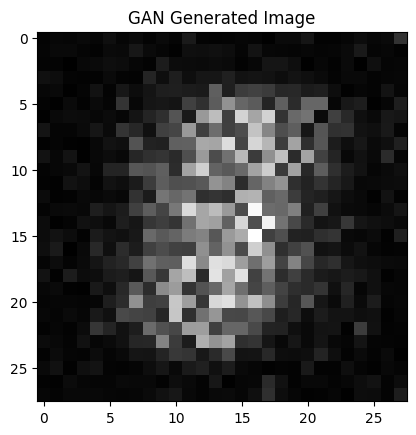

In [27]:

# Define a simple autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)  # compress to 3 features
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()  # output between 0-1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Define a simple GAN
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.Tanh()  # output between -1 and 1
        )
    
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()  # output between 0-1 (real or fake)
        )
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        return self.main(x)

# Training setup
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Initialize models
autoencoder = Autoencoder()
generator = Generator()
discriminator = Discriminator()

# Loss and optimizers
ae_criterion = nn.MSELoss()
ae_optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

gan_criterion = nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)

# Training functions
def train_autoencoder(epochs=5):
    for epoch in range(epochs):
        for data in train_loader:
            img, _ = data
            img = img.view(img.size(0), -1)
            
            # Forward pass
            output = autoencoder(img)
            loss = ae_criterion(output, img)
            
            # Backward pass and optimize
            ae_optimizer.zero_grad()
            loss.backward()
            ae_optimizer.step()
            
        print(f'Autoencoder Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

def train_gan(epochs=5):
    for epoch in range(epochs):
        for i, (imgs, _) in enumerate(train_loader):
            # Train Discriminator
            real_labels = torch.ones(imgs.size(0), 1)
            fake_labels = torch.zeros(imgs.size(0), 1)
            
            # Real images
            real_outputs = discriminator(imgs)
            d_loss_real = gan_criterion(real_outputs, real_labels)
            
            # Fake images
            z = torch.randn(imgs.size(0), 100)
            fake_imgs = generator(z)
            fake_outputs = discriminator(fake_imgs.detach())
            d_loss_fake = gan_criterion(fake_outputs, fake_labels)
            
            # Total discriminator loss
            d_loss = d_loss_real + d_loss_fake
            
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()
            
            # Train Generator
            fake_outputs = discriminator(fake_imgs)
            g_loss = gan_criterion(fake_outputs, real_labels)
            
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            
        print(f'GAN Epoch [{epoch+1}/{epochs}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}')

# Display results
def show_results():
    # Test autoencoder
    dataiter = iter(train_loader)
    images, _ = next(dataiter)
    img = images[0].view(1, -1)
    
    with torch.no_grad():
        output = autoencoder(img)
    
    # Plot original and reconstructed
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(img.view(28, 28), cmap='gray')
    axes[0].set_title('Original')
    axes[1].imshow(output.view(28, 28), cmap='gray')
    axes[1].set_title('Reconstructed')
    plt.show()
    
    # Test GAN
    z = torch.randn(1, 100)
    with torch.no_grad():
        generated_img = generator(z)
    
    plt.imshow(generated_img.view(28, 28).numpy(), cmap='gray')
    plt.title('GAN Generated Image')
    plt.show()

# Train models
print("Training Autoencoder...")
train_autoencoder(epochs=3)

print("Training GAN...")
train_gan(epochs=3)

# Show results
show_results()

Using randomly initialized  weights for demonstration
Prediction: Fake
Confidence: 50.69%


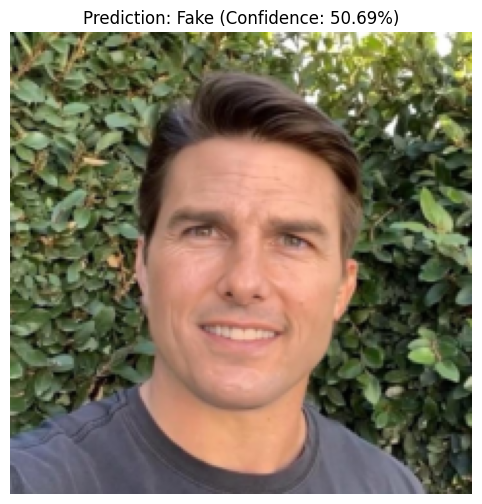

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests
from io import BytesIO

class LightweightDeepFakeDetector(nn.Module):
    def __init__(self, num_classes=2):
        super(LightweightDeepFakeDetector, self).__init__()
        
        # Simplified feature extractor (lightweight CNN)
        self.features = nn.Sequential(
            # First convolutional block
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1),
            
            # Second convolutional block
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.1),
            
            # Third convolutional block
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1),
            
            # Fourth convolutional block
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.1),
            
            # Adaptive pooling to ensure consistent output size
            nn.AdaptiveAvgPool2d((7, 7))
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(256 * 7 * 7, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Create a function to load a pretrained model (for demonstration purposes)
def load_pretrained_model(model_path=None):
    model = LightweightDeepFakeDetector()
    
    if model_path:
        # Load actual pretrained weights if available
        model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    else:
        # For demonstration, we'll use random weights (in a real scenario, you'd use actual trained weights)
        print("Using randomly initialized  weights for demonstration")
        
    model.eval()
    return model

# Image preprocessing
def preprocess_image(image_path, max_size=224):
    if image_path.startswith('http'):
        response = requests.get(image_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(image_path).convert('RGB')
    
    transform = transforms.Compose([
        transforms.Resize((max_size, max_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return transform(image).unsqueeze(0)

# Prediction function
def predict_deepfake(model, image_tensor):
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = F.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
        
    return "Real" if predicted.item() == 0 else "Fake", confidence.item()

# Visualization function
def visualize_prediction(image_tensor, prediction, confidence):
    image = image_tensor.squeeze(0).permute(1, 2, 0).numpy()
    image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    image = np.clip(image, 0, 1)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.title(f"Prediction: {prediction} (Confidence: {confidence:.2%})")
    plt.axis('off')
    plt.show()

# Example usage
if __name__ == "__main__":
    # Initialize model
    model = load_pretrained_model()
    
    # Example images (replace with your own images)
    real_image_url = "tom.jpeg"
    # For fake image, you would typically use a deepfake image from datasets like FaceForensics++
    
    # Load and preprocess image
    image_tensor = preprocess_image(real_image_url)
    
    # Make prediction
    prediction, confidence = predict_deepfake(model, image_tensor)
    
    # Display result
    print(f"Prediction: {prediction}")
    print(f"Confidence: {confidence:.2%}")
    
    # Visualize
    visualize_prediction(image_tensor, prediction, confidence)